# <center> Financial Econometrics with Python 2025 Project <center>

In [1]:
pip install  arch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


**Question 1**

In [3]:
import pandas as pd 
import numpy as np
import yfinance as yf
import pylab
import scipy.signal as ss
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.iolib.summary2 import summary_col
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

ftsemib = yf.download("FTSEMIB.MI", start="1997-12-31", end="2025-01-01")
ftsemib

C:\Users\julia\AppData\Local\Temp\ipykernel_2380\4007809938.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ftsemib = yf.download("FTSEMIB.MI", start="1997-12-31", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,FTSEMIB.MI,FTSEMIB.MI,FTSEMIB.MI,FTSEMIB.MI,FTSEMIB.MI
Date,,,,,
1997-12-31,24402.0,24402.0,24402.0,24402.0,0
1998-01-02,24914.0,24914.0,24914.0,24914.0,0
1998-01-05,25734.0,25734.0,25734.0,25734.0,0
1998-01-06,25734.0,25734.0,25734.0,25734.0,0
1998-01-07,25961.0,25961.0,25961.0,25961.0,0
...,...,...,...,...,...
2024-12-19,33787.0,34170.0,33708.0,34026.0,978558200
2024-12-20,33766.0,33793.0,33267.0,33519.0,855656400


In [4]:
#get prices
Pt_d = ftsemib["Close"]
Pt_d = Pt_d.rename(columns={Pt_d.columns[0]: "Pt.d"})
Pt_d.index = pd.to_datetime(Pt_d.index)

#make them logaritimic
pt_d = np.log(Pt_d).squeeze("columns") 
pt_d.name = "pt.d"

#monthly, yearly
pt_m = pt_d.resample('ME').last()
pt_y = pt_d.resample('YE').last()

#rename them 
pt_m.name = "pt.m"
pt_y.name = "pt.y"

#log-return of all the dataset
rt_d = pt_d.diff().dropna()
rt_d.name = "rt.d"

rt_m = pt_m.diff().dropna()
rt_m.name = "rt.m"

rt_y = pt_y.diff().dropna()
rt_y.name = "rt.y"


In [5]:
### Statistics Summary Table
X = {
    'daily': rt_d,
    'monthly': rt_m,
    'annual': rt_y
}

#funzione che fa i calcoli
def multi_fun(x):
    stat_tab = {
        'Mean': round(np.mean(x) * 100,5),
        'St.Deviation': round(np.std(x) * 100,5),
        'Diameter.C.I.Mean': round(1.96 * np.sqrt(np.var(x) / len(x)) * 100,5),
        'Sharpe.Ratio': round((np.mean(x) / np.std(x)), 5),
        'VaR.5.Percent': round(-np.quantile(x, 0.05) * 100, 5),
        'Max.Drawdown.Percent': round(np.min(((ec := np.exp(x).cumprod()) - (pk := ec.cummax())) / pk) * 100, 5),
        'Skewness': round(skew(x),5),
        'Kurtosis': round(kurtosis(x, fisher = False),5),
        'Excess.Kurtosis': round(kurtosis(x, fisher = False) - 3,5),
        'Min': round(np.min(x) * 100,5),
        'Quant5': round(np.quantile(x, 0.05) * 100,5),
        'Quant25': round(np.quantile(x, 0.25) * 100,5),
        'Median': round(np.quantile(x, 0.50) * 100,5),
        'Quant75': round(np.quantile(x, 0.75) * 100,5),
        'Quant95': round(np.quantile(x, 0.95) * 100,5),
        'Max': round(np.max(x) * 100,5),
        'Jarque.Bera.stat': round(jarque_bera(x)[0],5),
        'Jarque.Bera.pvalue.X100': round(jarque_bera(x)[1] *100,5),
        'Lillie.test.stat': round(lilliefors(x)[0],5),
        'Lillie.test.pvalue.X100': round(lilliefors(x)[1] * 100,5),
        'Kolmogorov.Smirnov.test' : round(kstest(x, 'norm')[0],5),
        'Kolmogorov.Smirnov.pvalue.X100' : round(kstest(x, 'norm')[1] * 100,5),
        'Anderson.Darling.test': round(anderson(x, 'norm')[0], 5),
        'N.obs': int(len(x))
    }
    return stat_tab

#dizionario per stampare la funzione
statistics_dict = {}

statistics_dict = {
    key: multi_fun(data) 
    for key, data in X.items()
}

statistics_df = pd.DataFrame(statistics_dict)

print(statistics_df)

#file in csv per download
#statistics_df.to_csv('statistics.csv', index_label='Statistics')

                                      daily    monthly    annual
Mean                                0.00489    0.10406   1.24871
St.Deviation                        1.50182    6.21840  22.41164
Diameter.C.I.Mean                   0.03544    0.67712   8.45372
Sharpe.Ratio                        0.00325    0.01673   0.05572
VaR.5.Percent                       2.43415   11.44343  31.30423
Max.Drawdown.Percent              -75.32779  -73.44417 -65.43905
Skewness                           -0.54126   -0.34171  -1.12973
Kurtosis                           11.27115    4.47770   4.34041
Excess.Kurtosis                     8.27115    1.47770   1.34041
Min                               -18.54611  -25.41061 -68.36988
Quant5                             -2.43415  -11.44343 -31.30423
Quant25                            -0.69702   -3.36324 -12.46871
Median                              0.06535    0.62589  11.89538
Quant75                             0.77093    3.83746  15.10426
Quant95                  

**Stylized Fact 2: Returns are stationary**

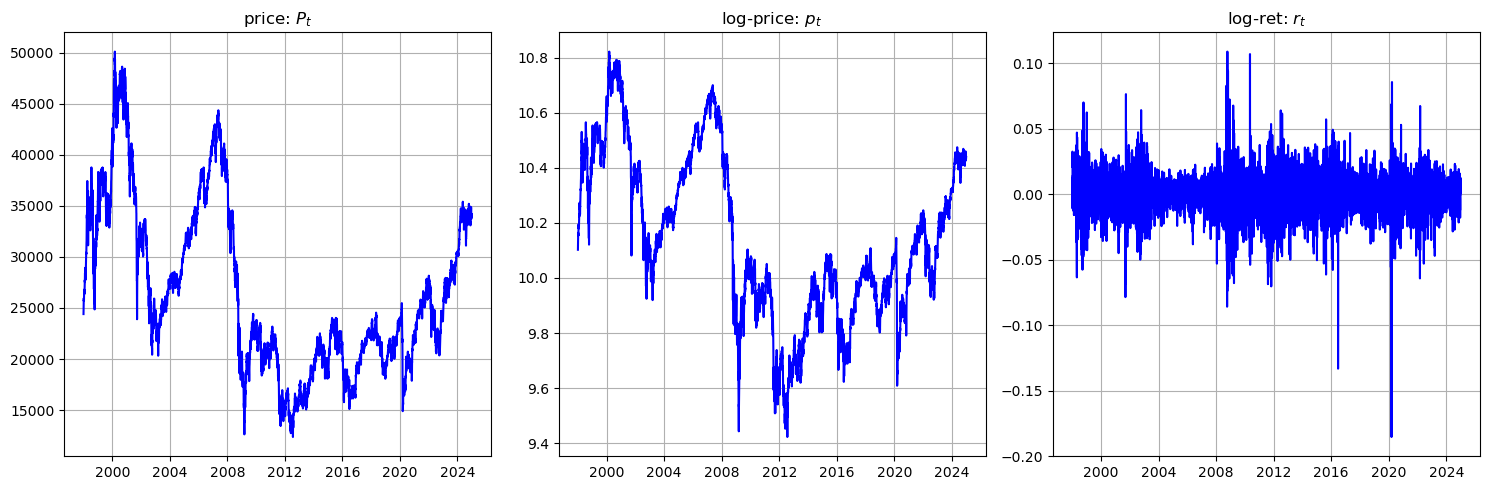

In [6]:
#plot prices and returns

# set the 1x3 windows layout
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# Daily Price
axs[0].plot(Pt_d.index, Pt_d, color='blue')
axs[0].set_title('price: $P_t$')
axs[0].grid(True)
# Daily log price
axs[1].plot(pt_d.index, pt_d, color='blue')
axs[1].set_title('log-price: $p_t$')
axs[1].grid(True)
# Daily log-returns 
axs[2].plot(rt_d.index, rt_d, color='blue')
axs[2].set_title('log-ret: $r_t$')
axs[2].grid(True)

# Manage margings and plot
plt.tight_layout()
#plt.savefig('price-log-ret.png') 
plt.show()

In [7]:
# Non Stationarity test ADF
# Function for Augmented Dickey-Fuller (ADF) test

def run_adf_test(series, name):
    if 'p' in name: # Log-prices 
        model = 'ct' 
        print(f"\nADF Test on {name} (Log-Prices - Model: Drift + Trend) ")
    else: # Log-returns
        model = 'c'
        print(f"\nADF Test on {name} (Log-Returns - Model: Drift) ")

    # ADF Test execution
    result = adfuller(series, autolag='AIC', regression=model)
    
    # Extract results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    # Interpretation
    is_stationary = p_value <= 0.05
    
    # Print for immediate feedback
    print(f"ADF Statistic: {adf_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"\t{key}: {value:.4f}")

    if is_stationary:
        print(f"CONCLUSION: Reject H0. Series {name} IS stationary at the 5% significance level.")
    else:
        print(f"CONCLUSION: DO NOT reject H0. Series {name} IS NON-STATIONARY.")
    
    # Returns the results in a structured format
    return {
        'Series': name,
        'ADF Statistic': round(adf_statistic, 4),
        'P-value': round(p_value, 4),
        'Critical 1%': round(critical_values['1%'], 4),
        'Critical 5%': round(critical_values['5%'], 4),
        'Critical 10%': round(critical_values['10%'], 4),
        'Regression Model': model,
        'Stationarity Outcome (5%)': 'STATIONARY' if is_stationary else 'NON-STATIONARY'
    }

#Log-prices 
results_pt_d = run_adf_test(pt_d, pt_d.name)

#Log-returns
results_rt_d = run_adf_test(rt_d, rt_d.name)

#Summary table
adf_df = pd.DataFrame([results_pt_d, results_rt_d])
adf_df = adf_df.set_index('Series') #Set the series (pt.d, rt.d) as index

print(adf_df)


ADF Test on pt.d (Log-Prices - Model: Drift + Trend) 
ADF Statistic: -1.9086
P-value: 0.6502
Critical Values:
	1%: -3.9601
	5%: -3.4111
	10%: -3.1274
CONCLUSION: DO NOT reject H0. Series pt.d IS NON-STATIONARY.

ADF Test on rt.d (Log-Returns - Model: Drift) 
ADF Statistic: -19.4239
P-value: 0.0000
Critical Values:
	1%: -3.4313
	5%: -2.8620
	10%: -2.5670
CONCLUSION: Reject H0. Series rt.d IS stationary at the 5% significance level.
        ADF Statistic  P-value  Critical 1%  Critical 5%  Critical 10%  \
Series                                                                   
pt.d          -1.9086   0.6502      -3.9601      -3.4111       -3.1274   
rt.d         -19.4239   0.0000      -3.4313      -2.8620       -2.5670   

       Regression Model Stationarity Outcome (5%)  
Series                                             
pt.d                 ct            NON-STATIONARY  
rt.d                  c                STATIONARY  


**Stylized Fact 3: Returns are asymmetric: negative skewness**

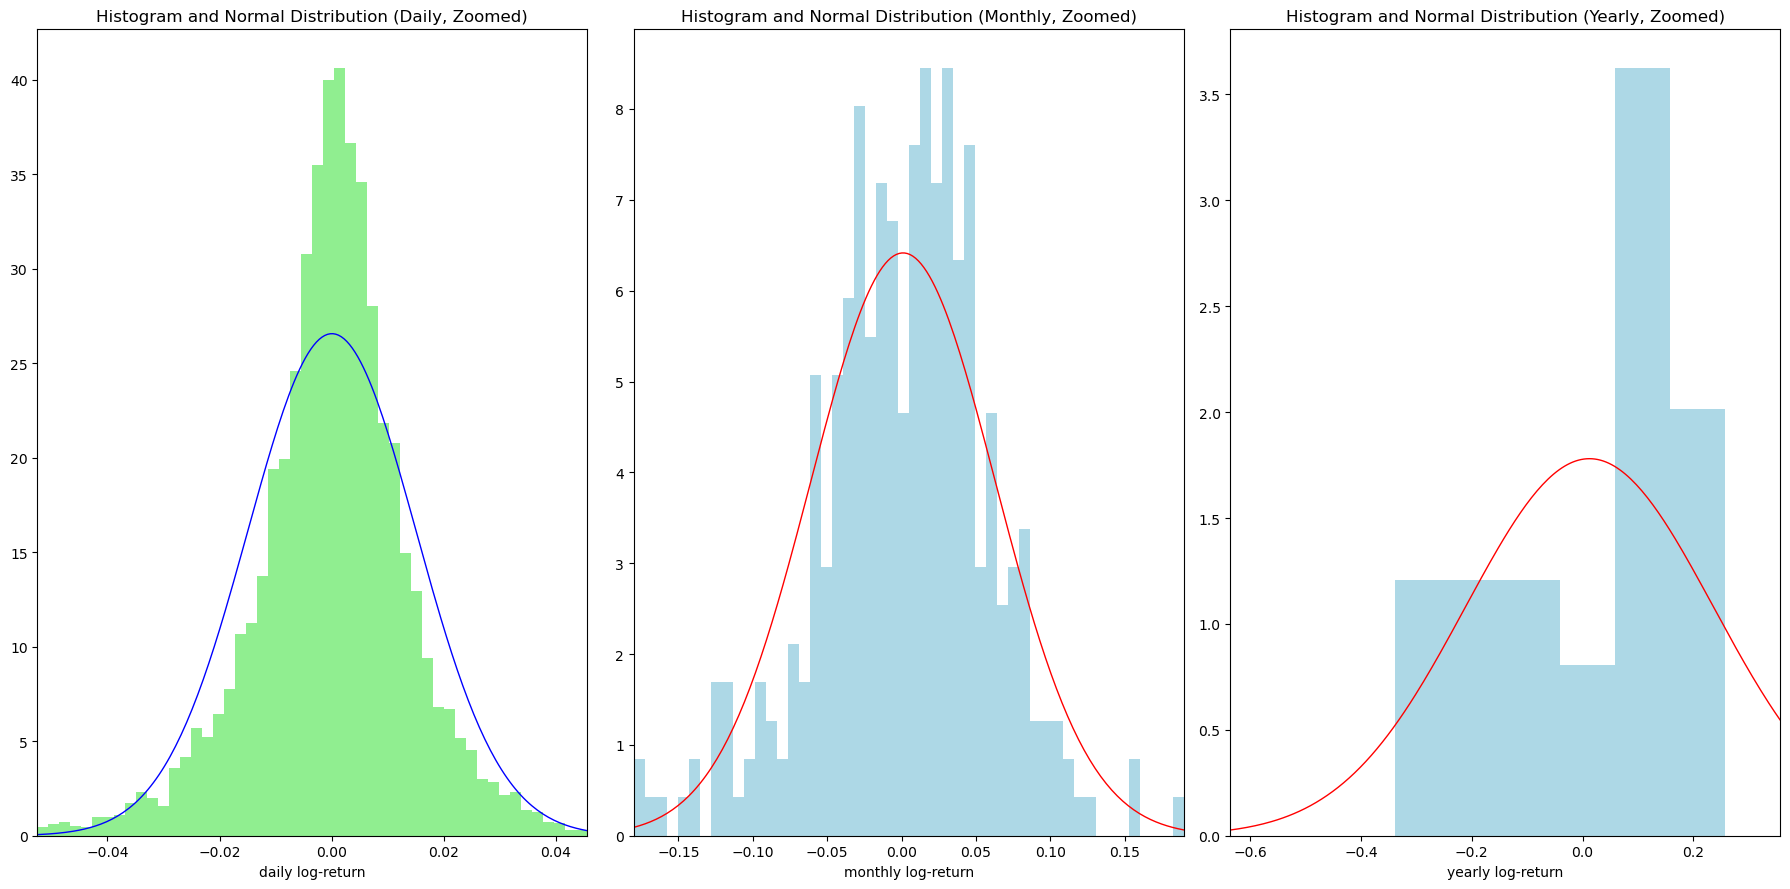

In [8]:
#Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

#Zoom in to improve the visibility in the graphs, takes out the 1% outliers 
min_d = rt_d.quantile(0.005)
max_d = rt_d.quantile(0.995)

#Histogram and Normal Distribution (Daily)
axs[0].hist(rt_d, bins=50, density=True, color="lightgreen", range=(min_d, max_d))
x_d = np.linspace(min_d, max_d, 200)
norm_y_d = stats.norm.pdf(x_d, loc=np.mean(rt_d), scale=np.std(rt_d))
axs[0].plot(x_d, norm_y_d, color="blue", linewidth=1)
axs[0].set_xlabel("daily log-return")
axs[0].set_title("Histogram and Normal Distribution (Daily, Zoomed)")
axs[0].set_xlim(min_d, max_d)

min_m = rt_m.quantile(0.005)
max_m = rt_m.quantile(0.995)

#Histogram and Normal Distribution (Monthly)
axs[1].hist(rt_m, bins=50, density=True, color="lightblue", range=(min_m, max_m))
x_m = np.linspace(min_m, max_m, 200)
norm_y_m = stats.norm.pdf(x_m, loc=np.mean(rt_m), scale=np.std(rt_m))
axs[1].plot(x_m, norm_y_m, color="red", linewidth=1)
axs[1].set_xlabel("monthly log-return")
axs[1].set_title("Histogram and Normal Distribution (Monthly, Zoomed)")
axs[1].set_xlim(min_m, max_m)

min_y = rt_y.quantile(0.005)
max_y = rt_y.quantile(0.995)

#Histogram and Normal Distribution (Yearly)
axs[2].hist(rt_y, bins=10, density=True, color="lightblue", range=(min_y, max_y))
x_y = np.linspace(min_y, max_y, 200)
norm_y_y = stats.norm.pdf(x_y, loc=np.mean(rt_y), scale=np.std(rt_y))
axs[2].plot(x_y, norm_y_y, color="red", linewidth=1)
axs[2].set_xlabel("yearly log-return")
axs[2].set_title("Histogram and Normal Distribution (Yearly, Zoomed)")
axs[2].set_xlim(min_y, max_y)

#Adjust layout and display the plot
plt.tight_layout()
#plt.savefig("Histograms of Normal Distributions.png")
plt.show()

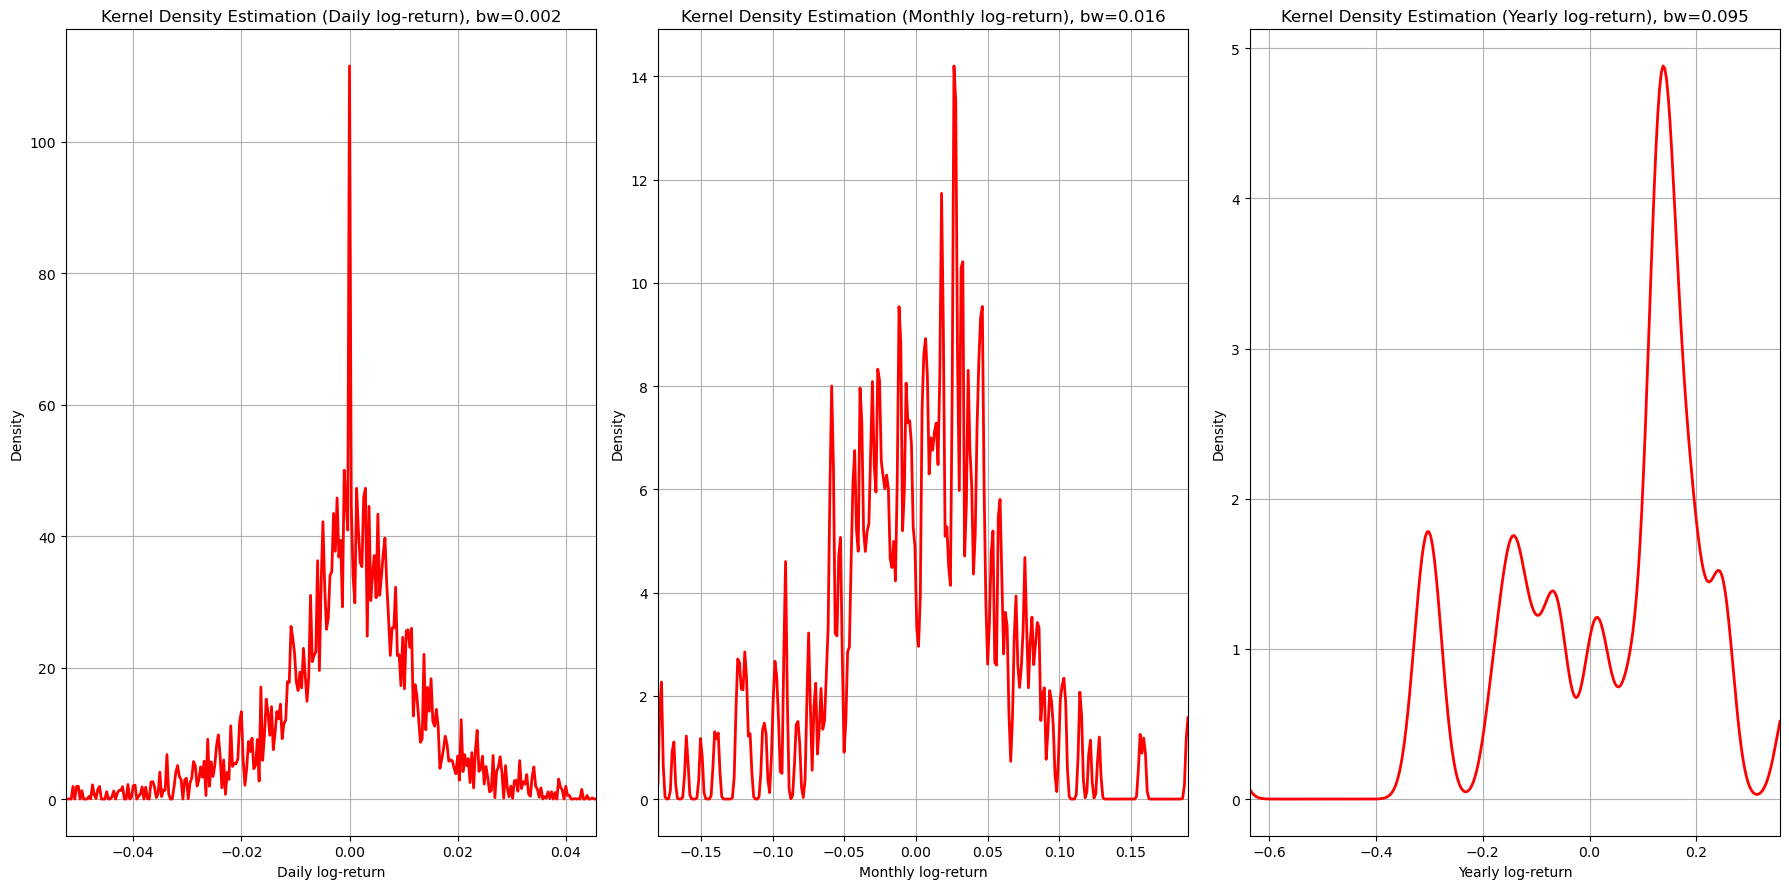

In [9]:
##Compute the kernel density
#divide the interval between the min and max returns into 300 segments

fig, axs = plt.subplots(1, 3, figsize=(18, 9)) 

#Zoom in to improve the visibility in the graphs, takes out the 1% outliers 
min_d = rt_d.quantile(0.005)
max_d = rt_d.quantile(0.995)

density_eval_points_d = np.linspace(min_d, max_d, num=300) 
#estimate the kernel density of our returns
kde_d = gaussian_kde(rt_d, bw_method=0.002)
#and evaluate in the interval defined above
density_estimation_d = kde_d(density_eval_points_d)

#Plotting (Daily)
axs[0].plot(density_eval_points_d, density_estimation_d, color='red', lw=2, label='Kernel density')
axs[0].set_xlabel("Daily log-return")
axs[0].set_ylabel("Density")
axs[0].set_title("Kernel Density Estimation (Daily log-return), bw=0.002")
axs[0].set_xlim(min_d, max_d) 
axs[0].grid(True)

min_m = rt_m.quantile(0.005)
max_m = rt_m.quantile(0.995)

density_eval_points_m = np.linspace(min_m, max_m, num=300) 
#estimate the kernel density of our returns
kde_m = gaussian_kde(rt_m, bw_method=0.016)
#and evaluate in the interval defined above
density_estimation_m = kde_m(density_eval_points_m)

#Plotting (Monthly)
axs[1].plot(density_eval_points_m, density_estimation_m, color='red', lw=2, label='Kernel density')
axs[1].set_xlabel("Monthly log-return")
axs[1].set_ylabel("Density")
axs[1].set_title("Kernel Density Estimation (Monthly log-return), bw=0.016")
axs[1].set_xlim(min_m, max_m) 
axs[1].grid(True)

min_y = rt_y.quantile(0.005)
max_y = rt_y.quantile(0.995)

density_eval_points_y = np.linspace(min_y, max_y, num=300) 
#estimate the kernel density of our returns
kde_y = gaussian_kde(rt_y, bw_method=0.095)
#and evaluate in the interval defined above
density_estimation_y = kde_y(density_eval_points_y)

#Plotting (Yearly)
axs[2].plot(density_eval_points_y, density_estimation_y, color='red', lw=2, label='Kernel density')
axs[2].set_xlabel("Yearly log-return")
axs[2].set_ylabel("Density")
axs[2].set_title("Kernel Density Estimation (Yearly log-return), bw=0.095") 
axs[2].set_xlim(min_y, max_y) 
axs[2].grid(True)

#Adjust layout and display the plot
plt.tight_layout()
#plt.savefig("Kernel_Density_Zoomed.png")
plt.show()

In [10]:
print("Daily Skewness:"  , round(skew(rt_d),5)),
print("Monthly Skewness:" , round(skew(rt_m),5)),
print("Yearly Skewness:" , round(skew(rt_y),5))

Daily Skewness: -0.54126
Monthly Skewness: -0.34171
Yearly Skewness: -1.12973


**Stylized Fact 4: Returns have heavy tails: large positive excess kurtosis**

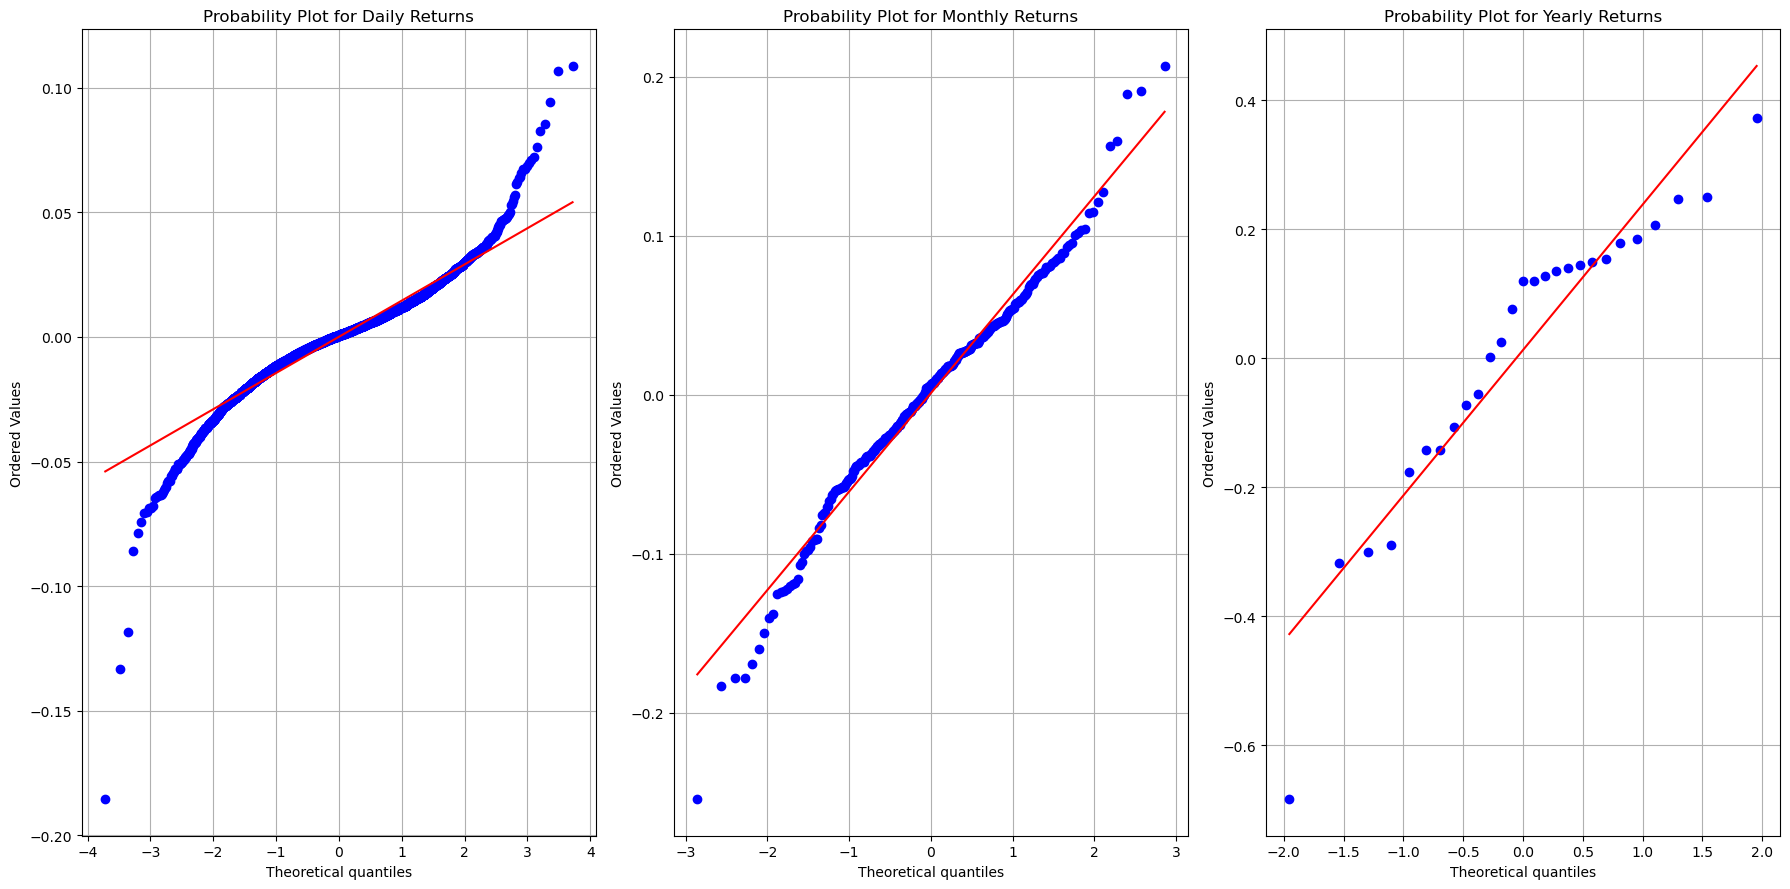

In [11]:
#Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

#Probability Plot for Daily Returns
stats.probplot(rt_d, dist="norm", plot=axs[0])
axs[0].set_title("Probability Plot for Daily Returns")
axs[0].grid(True)

#Probability Plot for Monthly Returns
stats.probplot(rt_m, dist="norm", plot=axs[1])
axs[1].set_title("Probability Plot for Monthly Returns")
axs[1].grid(True)

#Probability Plot for Yearly Returns
stats.probplot(rt_y, dist="norm", plot=axs[2])
axs[2].set_title("Probability Plot for Yearly Returns")
axs[2].grid(True)

#Adjust layout and display the plot
plt.tight_layout()
#plt.savefig("QQ Plots")
plt.show()

In [12]:
print("Daily Excess Kurtosis:"  , round(kurtosis(rt_d, fisher = False) - 3 ,5)),
print("Monthly Excess Kurtosis:" , round(kurtosis(rt_m, fisher = False) - 3 ,5)),
print("Yearly Excess Kurtosis" , round(kurtosis(rt_y, fisher = False) - 3 ,5))

Daily Excess Kurtosis: 8.27115
Monthly Excess Kurtosis: 1.4777
Yearly Excess Kurtosis 1.34041


**Stylized Fact 5: Aggregational Gaussianity: lower frequencies (i.e. aggregated) returns tend to 
be Gaussian, even if the higher frequency returns (daily) are not.**


In [14]:
print("Daily Skewness:"  , round(skew(rt_d) ,5)),
print("Monthly Skewness:" , round(skew(rt_m) ,5)),
print("Yearly Skewness" , round(skew(rt_y) ,5))

Daily Skewness: -0.54126
Monthly Skewness: -0.34171
Yearly Skewness -1.12973


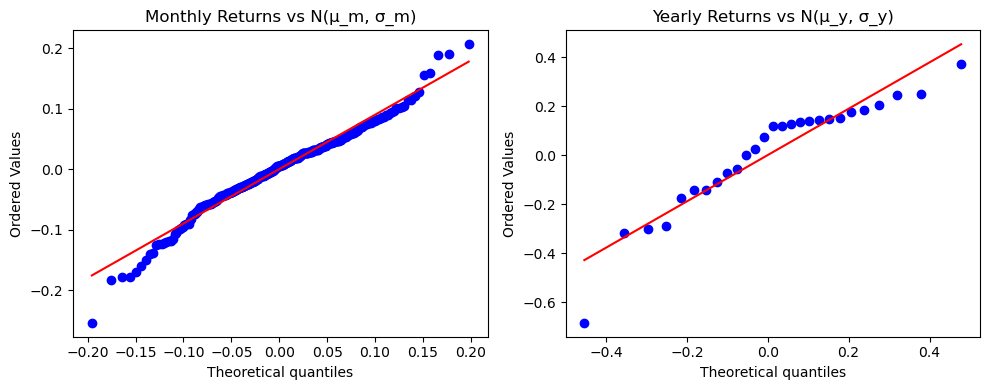

In [15]:
A_month = 21
A_year = 252

#simulate monthly and yearly returns under normality assumption
mu_d = rt_d.mean()
sigma_d = rt_d.std()

#theoretical scaled parameters
mu_m = mu_d * A_month
sigma_m = sigma_d * np.sqrt(A_month)
mu_y = mu_d * A_year
sigma_y = sigma_d * np.sqrt(A_year)

# Q plot of actual vs normal with scaled parameters
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
stats.probplot(rt_m, dist="norm", sparams=(mu_m, sigma_m), plot=axes[0])
axes[0].set_title("Monthly Returns vs N(μ_m, σ_m)")

stats.probplot(rt_y, dist="norm", sparams=(mu_y, sigma_y), plot=axes[1])
axes[1].set_title("Yearly Returns vs N(μ_y, σ_y)")

plt.tight_layout()
#plt.savefig("QQ Plot with Scaled Parameters")
plt.show()

**Stylized Fact 6: Returns are not autocorrelated**

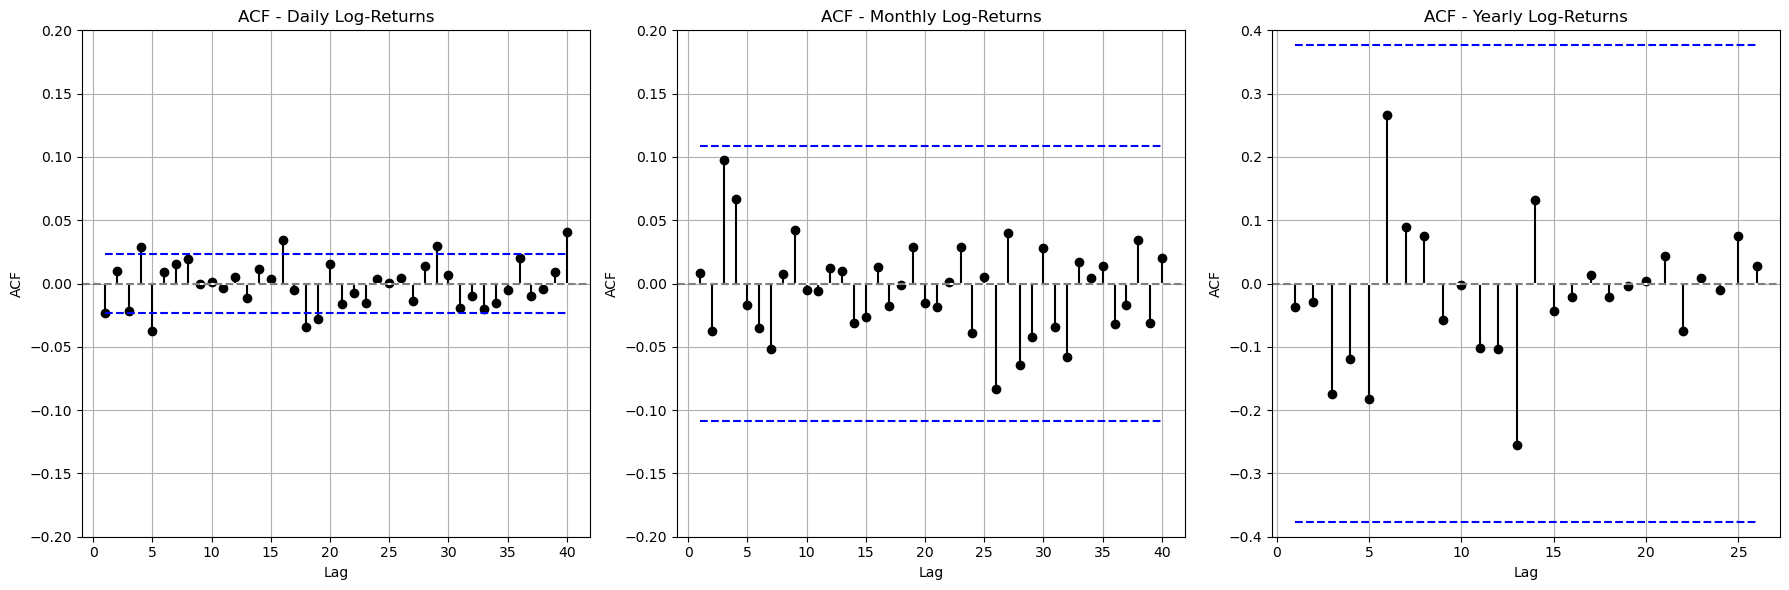

In [16]:
#Autocorrelation of Returns

lags = 40
acf_values_daily = acf(rt_d, nlags=lags)

#Compute the bartlet intervals
confint = 1.96 / np.sqrt(len(rt_d))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)

#Set the layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

#ACF of daily log-returns
axs[0].stem(np.arange(1, lags + 1), acf_values_daily[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.2, 0.2)
axs[0].set_title('ACF - Daily Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)

#ACF of monthly log-returns
acf_values_monthly = acf(rt_m, nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(rt_m))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)
axs[1].stem(np.arange(1, lags + 1), acf_values_monthly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.2, 0.2)
axs[1].set_title('ACF - Monthly Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].grid(True)

y_lags=26

#ACF of yearly log-returns
acf_values_yearly = acf(rt_y, nlags=y_lags)
confint_yearly = 1.96 / np.sqrt(len(rt_y))
confint_yearly_upper = np.full(y_lags, confint_yearly)
confint_yearly_lower = -np.full(y_lags, confint_yearly)

axs[2].stem(np.arange(1, y_lags + 1), acf_values_yearly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[2].axhline(y=0, color='gray', linestyle='--')
axs[2].plot(np.arange(1, y_lags + 1), confint_yearly_upper, color='blue', linestyle='dashed')
axs[2].plot(np.arange(1, y_lags + 1), confint_yearly_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-0.4, 0.4)
axs[2].set_title('ACF - Yearly Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].grid(True)

#Set the space
plt.tight_layout()
#plt.savefig("ACF.png")
plt.show()

In [17]:
print("Daily:", "+/-", round(1.96/np.sqrt(len(rt_d)),3))
print("Monthly:", "+/-", round(1.96/np.sqrt(len(rt_m)),3))
print("Yearly:", "+/-", round(1.96/np.sqrt(len(rt_y)),3))

Daily: +/- 0.024
Monthly: +/- 0.109
Yearly: +/- 0.377


In [18]:
#Box-pierce and Ljung Box statistics

my_max_lag = 40
lags_all = np.arange(1, my_max_lag + 1)
my_acf = sm.tsa.acf(rt_d, nlags=my_max_lag)
my_acf_diameter = 1.96 / np.sqrt(len(rt_d))
my_acf_tstat_0 = (my_acf[1:] - 0) / np.sqrt(1 / len(rt_d))
my_LjungBox = sm.stats.diagnostic.acorr_ljungbox(rt_d, lags=lags_all, boxpierce=False)
my_BoxPierce = sm.stats.diagnostic.acorr_ljungbox(rt_d, lags=lags_all, boxpierce=True)
crit_value_5_BP = stats.chi2.ppf(0.95,lags_all)

my_table = np.column_stack((
    lags_all,
    my_acf[1:],
    np.full(my_max_lag, my_acf_diameter),
    my_acf_tstat_0,
    my_BoxPierce['bp_stat'],
    my_BoxPierce['bp_pvalue'],
    my_LjungBox['lb_stat'],
    my_LjungBox['lb_pvalue'],
    np.full(my_max_lag, crit_value_5_BP)
))
column_names = ["lag", "acf", "acf diam.", "acf test", "B-P stat", "B-P pval", "L-B stat", "L-B pval", "crit"]
my_table_df = pd.DataFrame(data=my_table, columns=column_names)

#Print the rounded table
my_table_df = my_table_df.round(3)
my_table_df
#my_table_df.to_csv('Box-pierce-Ljung-Box-statistics.csv', index_label='Statistics')

,lag,acf,acf diam.,acf test,B-P stat,B-P pval,L-B stat,L-B pval,crit
0,1.0,-0.024,0.024,-1.956,3.826,0.050,3.828,0.050,3.841
1,2.0,0.010,0.024,0.833,4.521,0.104,4.523,0.104,5.991
2,3.0,-0.022,0.024,-1.805,7.777,0.051,7.782,0.051,7.815
3,4.0,0.029,0.024,2.376,13.421,0.009,13.430,0.009,9.488
4,5.0,-0.037,0.024,-3.114,23.118,0.000,23.137,0.000,11.070
5,6.0,0.009,0.024,0.730,23.650,0.001,23.670,0.001,12.592
6,7.0,0.015,0.024,1.250,25.213,0.001,25.235,0.001,14.067
7,8.0,0.019,0.024,1.605,27.790,0.001,27.816,0.001,15.507
8,9.0,-0.000,0.024,-0.016,27.790,0.001,27.816,0.001,16.919
9,10.0,0.002,0.024,0.126,27.806,0.002,27.832,0.002,18.307


**Stylized fact 7:Volatility clustering and long range dependence of squared returns**

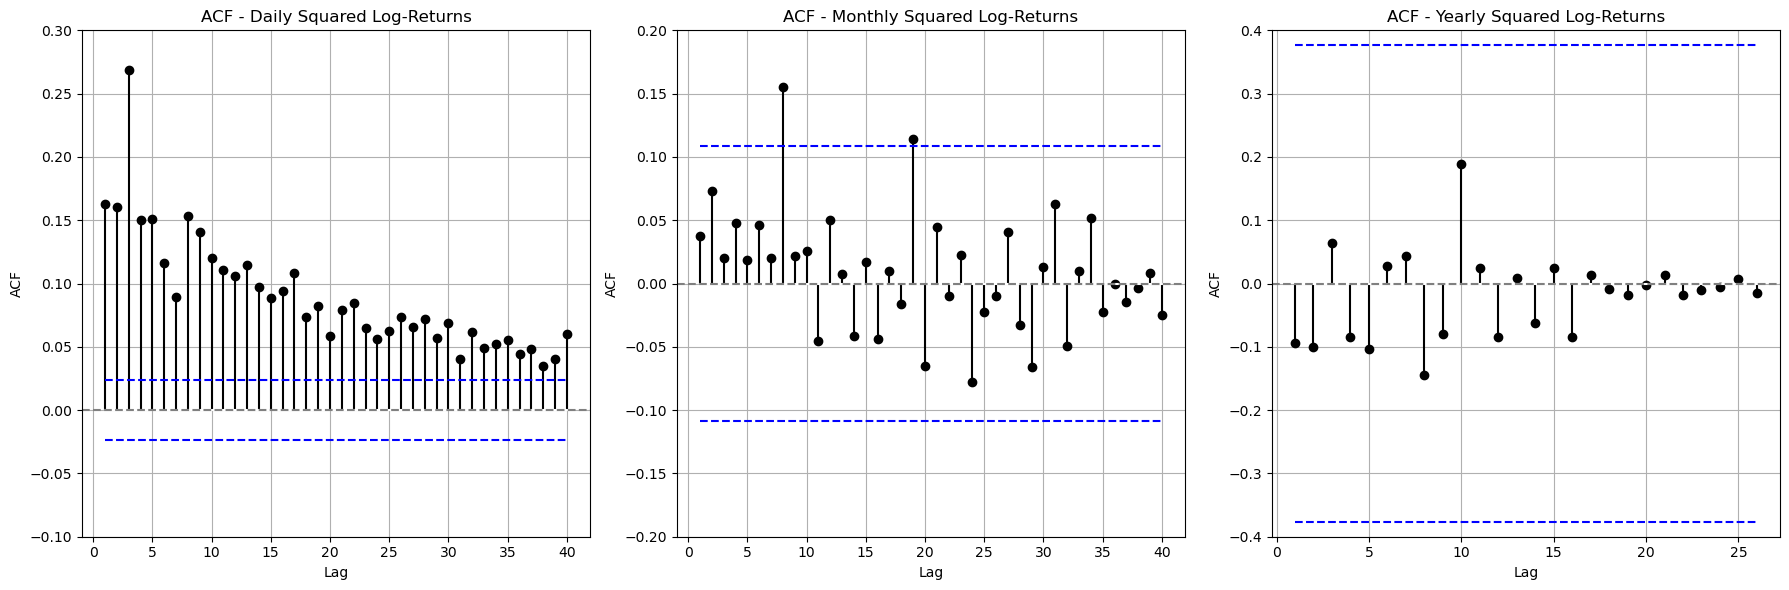

In [19]:
#Compute the empirical ACF (squared)
lags = 40
acf_values_daily = acf(rt_d**2, nlags=lags)

# Compute the bartlet intervals
confint = 1.96 / np.sqrt(len(rt_d))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)

#Set the layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

#ACF of daily log-returns
axs[0].stem(np.arange(1, lags + 1), acf_values_daily[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.1, 0.3)
axs[0].set_title('ACF - Daily Squared Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)

#ACF of squared monthly log-returns
acf_values_monthly = acf(rt_m**2, nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(rt_m))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)

axs[1].stem(np.arange(1, lags + 1), acf_values_monthly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.2, 0.2)
axs[1].set_title('ACF - Monthly Squared Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].grid(True)

#Change Yearly Lags 
y_lags = 26

# ACF of squared yearly log-returns
acf_values_yearly = acf(rt_y**2, nlags=y_lags)
confint_yearly = 1.96 / np.sqrt(len(rt_y))
confint_yearly_upper = np.full(y_lags, confint_yearly)
confint_yearly_lower = -np.full(y_lags, confint_yearly)

axs[2].stem(np.arange(1, y_lags + 1), acf_values_yearly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[2].axhline(y=0, color='gray', linestyle='--')
axs[2].plot(np.arange(1, y_lags + 1), confint_yearly_upper, color='blue', linestyle='dashed')
axs[2].plot(np.arange(1, y_lags + 1), confint_yearly_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-0.4, 0.4)
axs[2].set_title('ACF - Yearly Squared Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].grid(True)

#Set the space
plt.tight_layout()
#plt.savefig("ACF-Squared-Log-Returns.png") 
plt.show()

C:\Users\julia\AppData\Local\Temp\ipykernel_2380\2768592729.py:24: RuntimeWarning: divide by zero encountered in divide
  sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
C:\Users\julia\AppData\Local\Temp\ipykernel_2380\2768592729.py:24: RuntimeWarning: invalid value encountered in multiply
  sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
C:\Users\julia\AppData\Local\Temp\ipykernel_2380\2768592729.py:25: RuntimeWarning: divide by zero encountered in divide
  sd_plot_lb = roll_mom_manual[:,1]-1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
C:\Users\julia\AppData\Local\Temp\ipykernel_2380\2768592729.py:25: RuntimeWarning: invalid value encountered in multiply
  sd_plot_lb = roll_mom_manual[:,1]-1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)


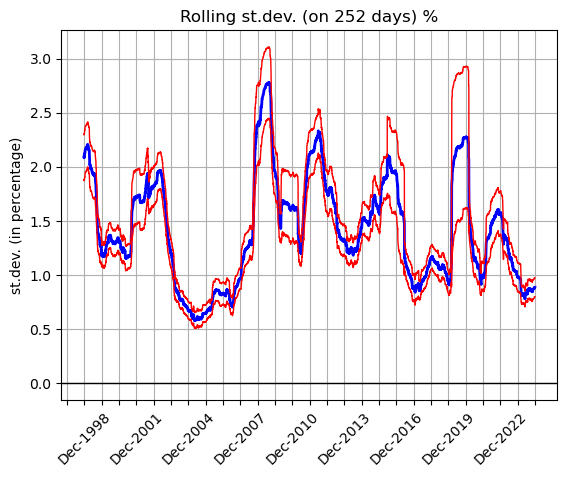

In [20]:
#Rolling Std-Dev

window_length = 252
T = rt_d.shape[0]

#Create an empty matrix to store data
roll_mom_manual = np.zeros((T, 5))

#Run a for loop to fill the matrix with moments
for i in range(window_length, T):
    est_window = np.arange(i - window_length + 1, i + 1)
    y = rt_d.iloc[est_window]
    
    # compute the moments for each 
    roll_mom_manual[i, 0] = np.mean(y)
    roll_mom_manual[i, 1] = np.std(y, ddof=1)
    roll_mom_manual[i, 2] = skew(y)
    roll_mom_manual[i, 3] = kurtosis(y)
    roll_mom_manual[i, 4] = np.mean((y - np.mean(y))**4)

#extract the Std Dev from roll_mom_manual
sd_plot = roll_mom_manual[:,1]
mu4 = roll_mom_manual[:,4]
sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
sd_plot_lb = roll_mom_manual[:,1]-1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)

data2plot_na = np.column_stack((sd_plot, sd_plot_lb, sd_plot_ub))

data_index = rt_d.index

data2plot_na = pd.DataFrame({'StD': sd_plot, 'LowerBound': sd_plot_lb, 'UpperBound': sd_plot_ub},
                               index=data_index)

#Select only rows without missing values
data2plot = data2plot_na.dropna()
#retrieve the data index
data2plot

#Customizing x-axis labels for December 31 of each year
date_labels = pd.date_range(start='1997-12-31', end='2025-01-01', freq='YE-DEC')
#Show 1 tick every 3 years
formatted_labels = [f'Dec-{date.year}' if date.year % 3 == 0 else '' for date in date_labels]
#Add labels and rotate them 
plt.xticks(date_labels, formatted_labels, rotation=45)

#Plot the data
plt.plot(data2plot.index, data2plot["StD"] * 100, color='blue', linestyle='-', linewidth=2)
plt.plot(data2plot.index, data2plot["LowerBound"] * 100, color='red', linestyle='-', linewidth=1)
plt.plot(data2plot.index, data2plot["UpperBound"] * 100, color='red', linestyle='-', linewidth=1)
plt.xlabel('')
plt.grid(True)
plt.ylabel('st.dev. (in percentage)')
plt.title('Rolling st.dev. (on 252 days) %')
plt.axhline(0, linestyle='-', color='black', linewidth=1)  # Add a zero line

plt.show()

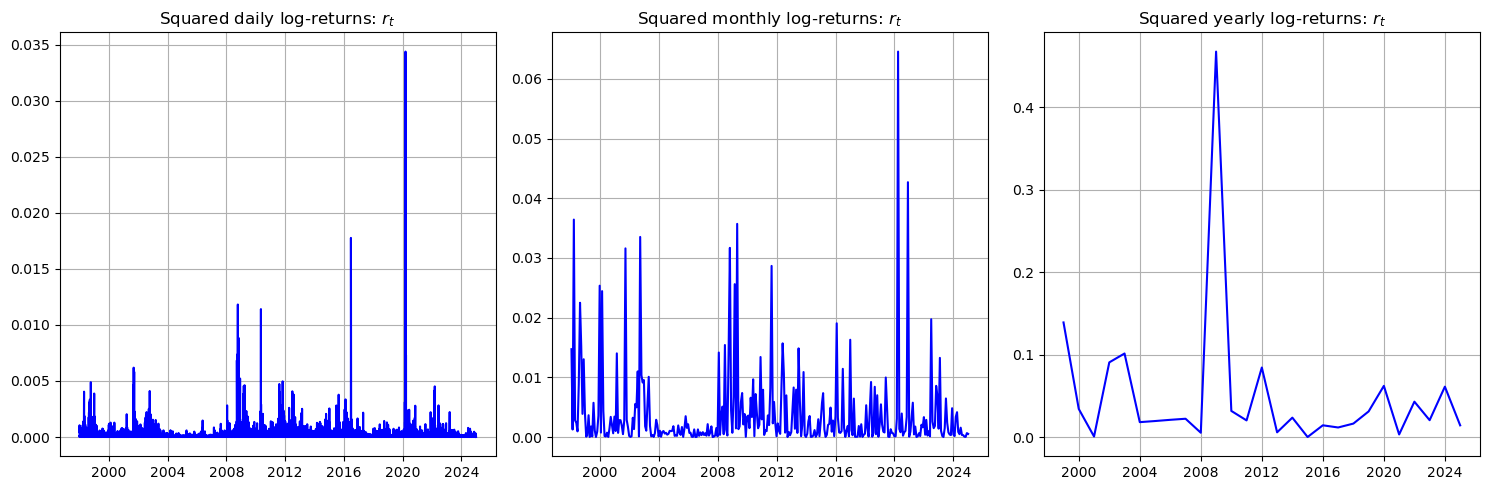

In [21]:
#Squared Log-Returns

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Daily log-returns^2
axs[0].plot(rt_d.index,rt_d**2, color='blue')
axs[0].set_title('Squared daily log-returns: $r_t$')
axs[0].grid(True)

# Monthly log-returns^2
axs[1].plot(rt_m.index, rt_m**2, color='blue')
axs[1].set_title('Squared monthly log-returns: $r_t$')
axs[1].grid(True)

# Yearly log-returns^2
axs[2].plot(rt_y.index,rt_y**2, color='blue')
axs[2].set_title('Squared yearly log-returns: $r_t$')
axs[2].grid(True)

plt.tight_layout()
#plt.savefig("Squared-Log-Returns.png")
plt.show()

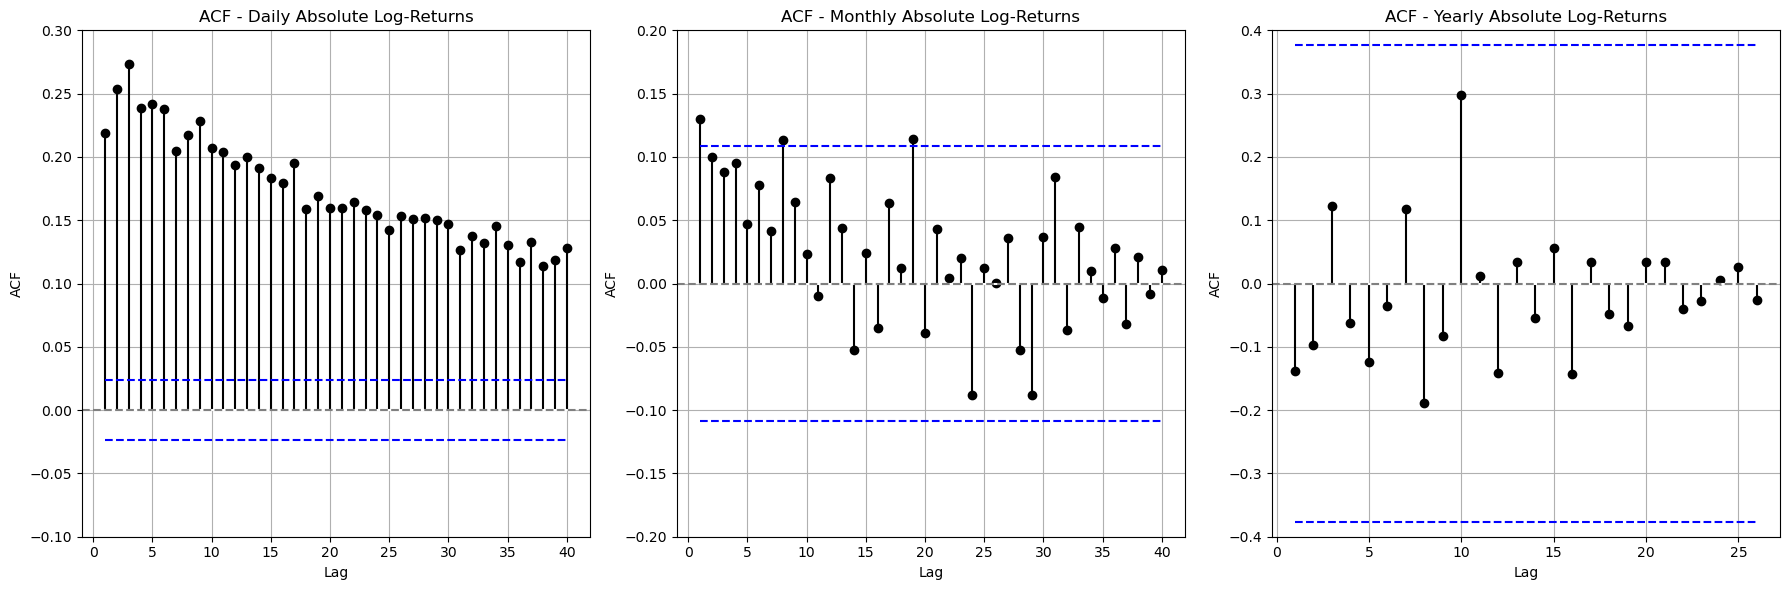

In [22]:
#Compute the empirical ACF of Absolute Returns

lags = 40
acf_values_daily = acf(abs(rt_d), nlags=lags)

#Compute the bartlet intervals
confint = 1.96 / np.sqrt(len(rt_d))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)

#Set the layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

#ACF of daily log-returns
axs[0].stem(np.arange(1, lags + 1), acf_values_daily[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.1, 0.3)
axs[0].set_title('ACF - Daily Absolute Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)

#ACF of abs monthly log-returns
acf_values_monthly = acf(abs(rt_m), nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(rt_m))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)

axs[1].stem(np.arange(1, lags + 1), acf_values_monthly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.2, 0.2)
axs[1].set_title('ACF - Monthly Absolute Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].grid(True)

y_lags = 26

#ACF of abs yearly log-returns
acf_values_yearly = acf(abs(rt_y), nlags=y_lags)
confint_yearly = 1.96 / np.sqrt(len(rt_y))
confint_yearly_upper = np.full(y_lags, confint_yearly)
confint_yearly_lower = -np.full(y_lags, confint_yearly)

axs[2].stem(np.arange(1, y_lags + 1), acf_values_yearly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[2].axhline(y=0, color='gray', linestyle='--')
axs[2].plot(np.arange(1, y_lags + 1), confint_yearly_upper, color='blue', linestyle='dashed')
axs[2].plot(np.arange(1, y_lags + 1), confint_yearly_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-0.4, 0.4)
axs[2].set_title('ACF - Yearly Absolute Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].grid(True)

#Set the space
plt.tight_layout()

plt.show()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1344.1385905473112
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1051.926606173984
Iteration:      3,   Func. Count:     16,   Neg. LLF: 1048.6663341054405
Iteration:      4,   Func. Count:     21,   Neg. LLF: 1045.4768652838256
Iteration:      5,   Func. Count:     26,   Neg. LLF: 1045.1518393597364
Iteration:      6,   Func. Count:     30,   Neg. LLF: 1045.1085903214334
Iteration:      7,   Func. Count:     34,   Neg. LLF: 1045.103433660574
Iteration:      8,   Func. Count:     38,   Neg. LLF: 1045.1006689519688
Iteration:      9,   Func. Count:     42,   Neg. LLF: 1045.1006615171202
Iteration:     10,   Func. Count:     46,   Neg. LLF: 1045.1006612557721
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1045.1006612557721
            Iterations: 10
            Function evaluations: 46
            Gradient evaluations: 10
                       Zero Mean - GARCH Model Results        

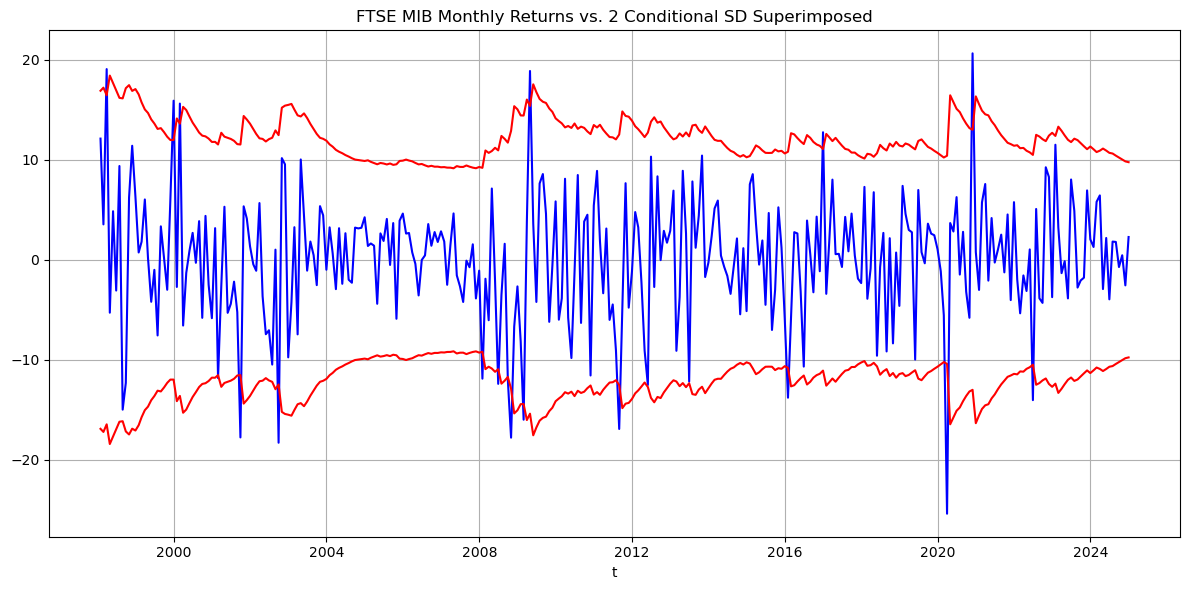

In [23]:
#GARCH (1,1)

#The arch library expects returns in percentage terms
returns_percent = rt_m * 100

#GARCH(1,1) model Specification
garch_spec11 = arch_model(returns_percent, vol='Garch', p=1, q=1, mean='Zero',rescale =False)

#Model Estimation
garch_fit11 = garch_spec11.fit()

#Display Results
print(garch_fit11)
results_df = pd.DataFrame({
    'Parameter': garch_fit11.params,
    'Std Err': garch_fit11.std_err,
    'T-stat': garch_fit11.tvalues,
    'P-value': garch_fit11.pvalues
})
results_df.to_csv('garch-model-data.csv', index_label='Variable')

#Extract Conditional Volatility for plotting

conditional_volatility = garch_fit11.conditional_volatility

# Plotting Conditional Volatility 
plt.figure(figsize=(12, 6))
plt.plot(returns_percent, color='blue')
plt.xlabel('t')
plt.plot(2 * conditional_volatility, color='red', label='Upper Volatility Bound')
plt.plot(-2 * conditional_volatility, color='red', label='Lower Volatility Bound')
plt.ylabel('')
plt.title(r'FTSE MIB Monthly Returns vs. 2 Conditional SD Superimposed')
plt.grid(True)
plt.tight_layout()
#plt.savefig("GARCH.png")
plt.show()

**Stylized Fact 8: Leverage effect**

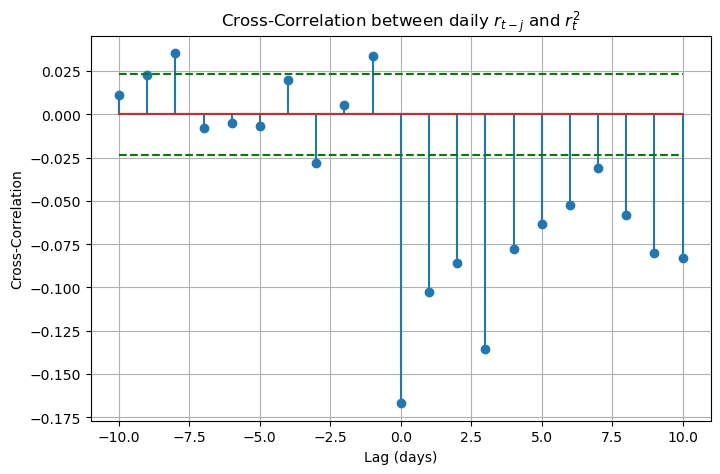

In [24]:
#Compute squadred returns
rt_d2 = rt_d**2

def ccf(x, y, lag_max = 100):
    # compute correlation
    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    # define the length
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

lag_max = 10
cross_corr = ccf(rt_d,rt_d2,lag_max=lag_max)

lags = np.arange(-lag_max, lag_max + 1)

# ACF of monthly log-returns with confidence intervals
confint_daily = 1.96 / np.sqrt(len(rt_d))
confint_daily_upper = np.full(len(lags), confint_daily)
confint_daily_lower = -np.full(len(lags), confint_daily)

plt.figure(figsize=(8, 5))
plt.stem(lags, cross_corr)
plt.plot(lags, confint_daily_upper, color='green', linestyle='dashed')
plt.plot(lags, confint_daily_lower, color='green', linestyle='dashed')
plt.xlabel('Lag (days)')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between daily $r_{t-j}$ and $r_t^2$')
plt.grid(True)
#plt.savefig("Cross-Correlation.png")
plt.show()

**Question 2**

In [25]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [26]:
#Import the FF Monthly Factors from the .csv file donwloaded from https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

FF_factors = pd.read_csv(
    "F-F_Research_Data_Factors.csv", 
    sep=",", 
    skiprows=3, 
    header=0, 
    parse_dates=[0], 
    date_format="%Y%m",
    index_col=0
)

#Rename Date column
FF_factors = FF_factors.rename_axis("Date")

#Offset (Month End)
FF_factors.index = FF_factors.index + pd.offsets.MonthEnd(0) 

#Risk-free and FFM factors
rf = FF_factors.iloc[:, 3].to_frame() 
ffm = FF_factors.iloc[:, 0:3]

rt_m.name = "FTSEMIB.MI"

#Merge all togheter
rt_m_all = ffm.join(rt_m * 100, how='inner').join(rf, how='inner')

rt_m_all.head()

,Mkt-RF,SMB,HML,FTSEMIB.MI,RF
Date,,,,,
1998-01-31,0.15,-1.01,-1.68,12.130114,0.43
1998-02-28,7.03,0.13,-0.93,3.544548,0.39
1998-03-31,4.76,-1.19,1.38,19.085110,0.39
1998-04-30,0.74,0.06,1.03,-5.293247,0.43
1998-05-31,-3.07,-3.40,3.41,4.860993,0.40


In [27]:
#Excess returns
rt_m_all['Exc_Ret_FTSE'] = rt_m_all['FTSEMIB.MI'] - rt_m_all['RF']
rt_m_df = rt_m_all

#Prepare the DataFrame for the regression
z_m_all = rt_m_all.drop(["RF", "FTSEMIB.MI"], axis=1)
z_m_df = z_m_all

print(z_m_df.head())

            Mkt-RF   SMB   HML  Exc_Ret_FTSE
Date                                        
1998-01-31    0.15 -1.01 -1.68     11.700114
1998-02-28    7.03  0.13 -0.93      3.154548
1998-03-31    4.76 -1.19  1.38     18.695110
1998-04-30    0.74  0.06  1.03     -5.723247
1998-05-31   -3.07 -3.40  3.41      4.460993


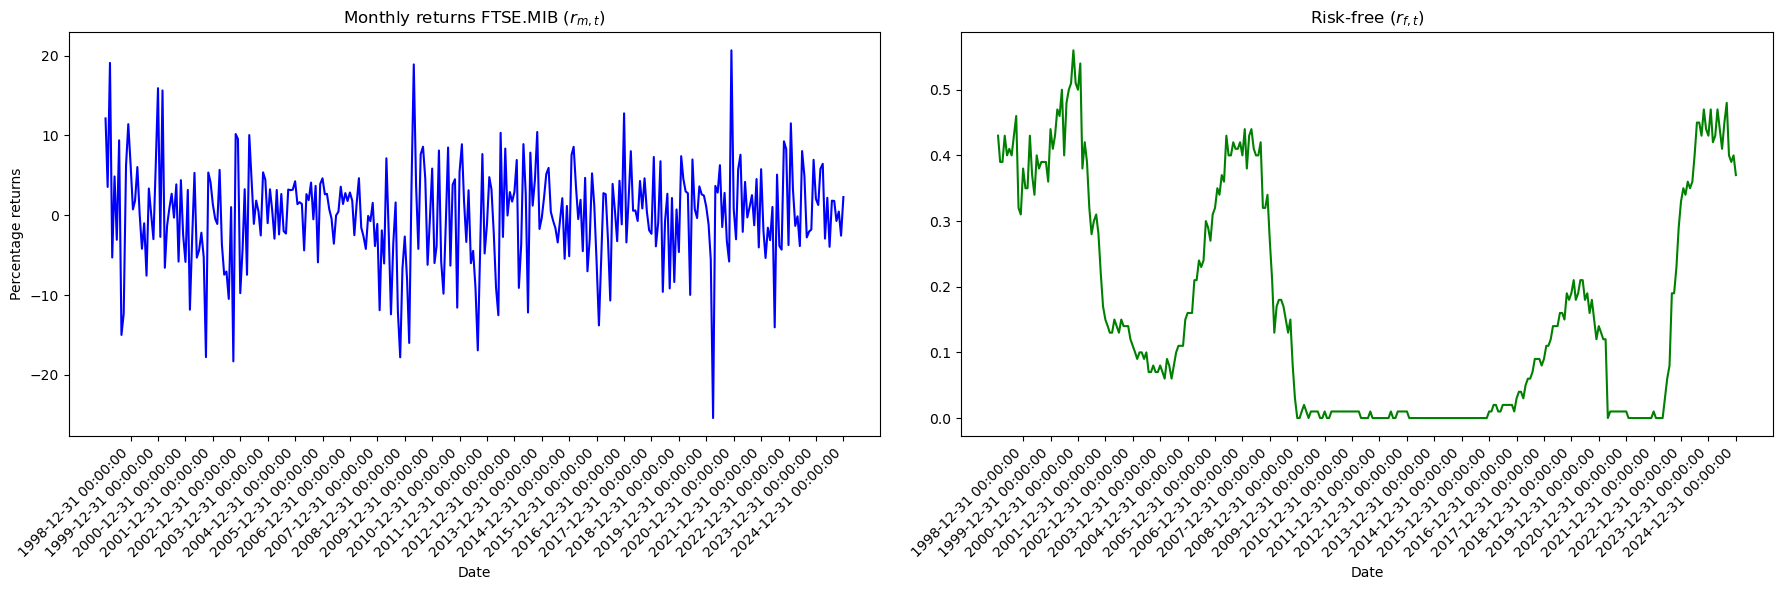

In [28]:
#Plot returns and risf-free rate
d2plot = rt_m_df
seq_sel = list(range(11, len(d2plot), 12))
date_lab = d2plot.index[seq_sel]

#define a 1x3 grid for the 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

#FTSE
axs[0].plot(d2plot.index, d2plot['FTSEMIB.MI'], linestyle='-', marker='', color='blue')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Percentage returns')
axs[0].set_title('Monthly returns FTSE.MIB ($r_{m,t}$)')
axs[0].set_xticks(date_lab)
axs[0].set_xticklabels(date_lab, rotation=45, ha="right")

#r-f
axs[1].plot(d2plot.index, d2plot['RF'], linestyle='-', marker='', color='green')
axs[1].set_xlabel('Date')
axs[1].set_title('Risk-free ($r_{f,t}$)')
axs[1].set_xticks(date_lab)
axs[1].set_xticklabels(date_lab, rotation=45, ha="right")

plt.tight_layout()
#plt.savefig('FTSE.MIB and Risk-Free Separati.png')
plt.show()

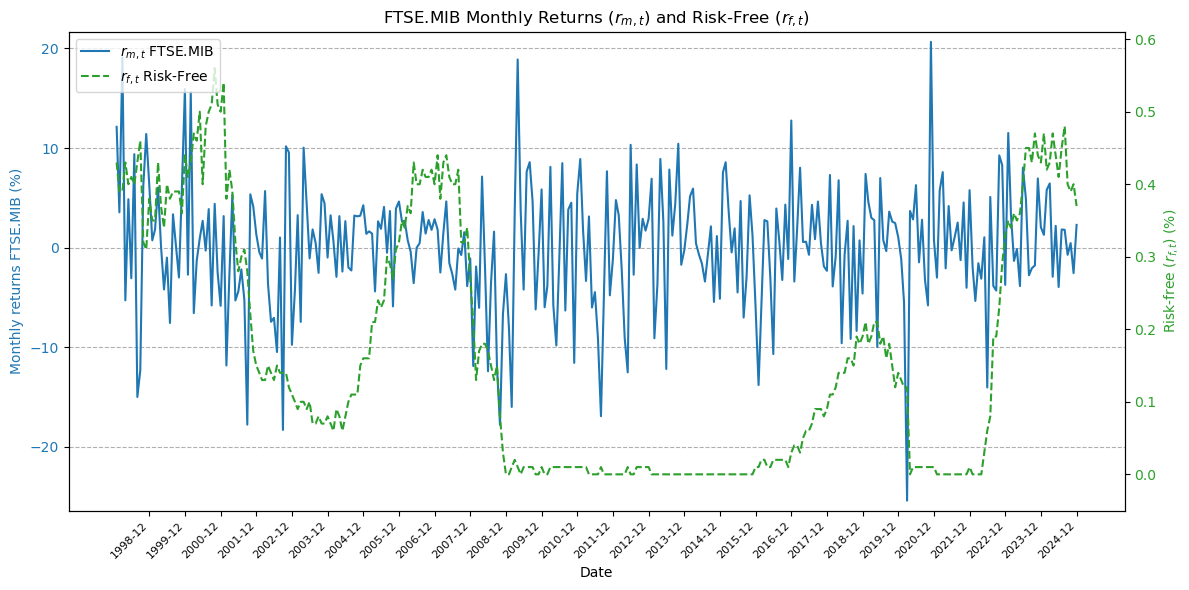

In [29]:
#Merge the graphs togheter
date_labels = date_lab 

min_ftse = d2plot['FTSEMIB.MI'].min() -1
max_ftse = d2plot['FTSEMIB.MI'].max() +1

min_rf = d2plot['RF'].min() - 0.05 
max_rf = d2plot['RF'].max() + 0.05

fig, ax1 = plt.subplots(figsize=(12, 6))

color_ftse = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly returns FTSE.MIB (%)', color=color_ftse)
ax1.plot(d2plot.index, d2plot['FTSEMIB.MI'], color=color_ftse, label=r'$r_{m,t}$ FTSE.MIB')
ax1.tick_params(axis='y', labelcolor=color_ftse)
ax1.set_ylim(min_ftse, max_ftse)
ax1.grid(True, linestyle='--', axis='y') # Griglia per il primo asse

ax1.set_xticks(date_labels)
ax1.set_xticklabels([d.strftime('%Y-%m') for d in date_labels], rotation=45, ha="right")
ax1.tick_params(axis='x', labelsize=8)

ax2 = ax1.twinx()  # Crea un secondo asse Y che condivide l'asse X
color_rf = 'tab:green'
ax2.set_ylabel('Risk-free ($r_{f,t}$) (%)', color=color_rf)
ax2.plot(d2plot.index, d2plot['RF'], color=color_rf, linestyle='--', label=r'$r_{f,t}$ Risk-Free')
ax2.tick_params(axis='y', labelcolor=color_rf)
ax2.set_ylim(min_rf, max_rf)

plt.title(r'FTSE.MIB Monthly Returns ($r_{m,t}$) and Risk-Free ($r_{f,t}$)')

#Legenda 
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
#plt.savefig('FTSE.MIB and Risk-Free.png')
plt.show()

In [30]:
#Summary table
def multi_fun(x):
    stats = np.array([np.mean(x), np.std(x,ddof=1),skew(x),kurtosis(x)+3,
        kurtosis(x),
        np.min(x),
        np.percentile(x, 5),
        np.percentile(x, 25),
        np.median(x),
        np.percentile(x, 75),
        np.percentile(x, 95),
        np.max(x),
        sm.stats.acorr_ljungbox(x, lags=[1], boxpierce=False).values[0][1],
        sm.stats.acorr_ljungbox(x, lags=[12], boxpierce=False).values[0][1],
        jarque_bera(x)[1],
        lilliefors(x)[1],
        len(x)])
    return stats

#Apply "multifunction": 
columns_to_apply = ['Mkt-RF' , 'FTSEMIB.MI' , 'RF']
data_stat = rt_m_df[columns_to_apply]
# 'a' is the table of summary statistics you can copy-paste
a = data_stat.apply(lambda x: multi_fun(x))
#change the rownames
a.index = ["Mean", "St.Deviation","Skewness","Kurtosis","ExcessKurtosis","Min","Quant.5%","Quant.25%","Median.50%","Quant.75%","Quant.95%","Max","Lj.Box.lag.1.pval","Lj.Box.lag.12.pval","Jarque.Bera.pval","Lillie.test.pval.X100","N.obs"]
round(a,5) # to round at the 5th digit

,Mkt-RF,FTSEMIB.MI,RF
Mean,0.67012,0.10406,0.16506
St.Deviation,4.64313,6.22802,0.16932
Skewness,-0.57499,-0.34171,0.61377
Kurtosis,3.89355,4.47770,1.87012
ExcessKurtosis,0.89355,1.47770,-1.12988
Min,-17.20000,-25.41061,0.00000
Quant.5%,-8.06150,-11.44343,0.00000
Quant.25%,-2.03250,-3.36324,0.01000
Median.50%,1.22500,0.62589,0.11000
Quant.75%,3.48000,3.83746,0.34000


In [31]:
#Scatterplot and simple regression: 
#CAPM monthly data

#FTSE monthly excess ret. 
y = z_m_df['Exc_Ret_FTSE']

#Market excess ret. 
x1 = z_m_df['Mkt-RF'] 

#Linear Regression
X = sm.add_constant(x1)  
reg1 = sm.OLS(y, X).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Exc_Ret_FTSE   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     289.0
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           1.05e-46
Time:                        22:35:57   Log-Likelihood:                -947.77
No. Observations:                 324   AIC:                             1900.
Df Residuals:                     322   BIC:                             1907.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6786      0.254     -2.672      0.008      -1.178      -0.179
Mkt-RF         0.9216      0.054     17.000      0.000       0.815       1.028
==============================================================================
Omnibus:                       10.960   Durbin-Watson:                   2.264
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               20.328
Skew:                          -0.123   Prob(JB):                     3.85e-05
Kurtosis:                       4.202   Cond. No.                         4.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
summary = summary_col([reg1], stars=True, float_format="%.4f", model_names=["FTSE.MIB CAPM"])
summary

,FTSE.MIB CAPM
const,-0.6786***
,(0.2539)
Mkt-RF,0.9216***
,(0.0542)
R-squared,0.4730
R-squared Adj.,0.4714


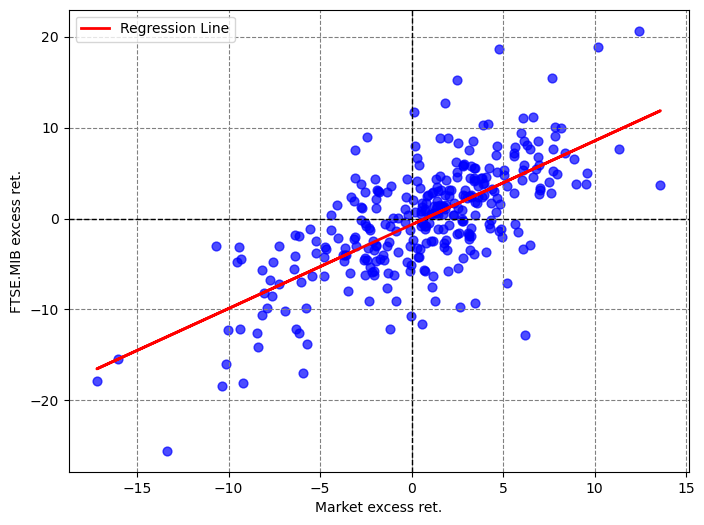

In [33]:
#Represent the predicted values through an histogram

plt.figure(figsize=(8, 6))
plt.scatter(x1, y, color="blue", s=40, alpha=0.7)
plt.xlabel("Market excess ret.")
plt.ylabel("FTSE.MIB excess ret.")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.grid(linestyle="--", color="grey")

#Compute the predicted values
y_pred = reg1.predict(X)

#Draw the regression line in red
plt.plot(x1, y_pred, color="red", linewidth=2, label="Regression Line")

plt.legend()
#plt.savefig("FTSE.MIB_Scatterplot_Regline.png")

plt.show()

In [34]:
#Fama-French 3 Factors Model
FTSE = z_m_df['Exc_Ret_FTSE']  # Excess_Return
MKT = z_m_df['Mkt-RF']  # Mkt-RF
SMB = z_m_df['SMB']  # SMB
HML = z_m_df['HML']  # HML

X2_Factors = np.column_stack(( MKT, SMB, HML)) 
X2 = sm.add_constant(X2_Factors)

#Perform linear regressions
reg2 = sm.OLS(FTSE, X2).fit() 

#Show summary
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Exc_Ret_FTSE   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     100.8
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           6.04e-46
Time:                        22:35:58   Log-Likelihood:                -943.79
No. Observations:                 324   AIC:                             1896.
Df Residuals:                     320   BIC:                             1911.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6954      0.252     -2.763      0.006      -1.191      -0.200
x1             0.9161      0.056     16.417      0.000       0.806       1.026
x2             0.0861      0.081      1.067      0.287      -0.073       0.245
x3             0.2001      0.073      2.733      0.007       0.056       0.344
==============================================================================
Omnibus:                        9.701   Durbin-Watson:                   2.305
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               17.888
Skew:                          -0.060   Prob(JB):                     0.000131
Kurtosis:                       4.145   Cond. No.                         4.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
summary2 = summary_col([reg2], stars=True, float_format="%.4f", model_names=["FTSE.MIB"])
summary2

,FTSE.MIB
const,-0.6954***
,(0.2517)
x1,0.9161***
,(0.0558)
x2,0.0861
,(0.0807)
x3,0.2001***
,(0.0732)
R-squared,0.4858
R-squared Adj.,0.4810


In [36]:
columns_to_analyze = ['Exc_Ret_FTSE', 'Mkt-RF', 'SMB', 'HML']
mat_summ_stat_input = z_m_df[columns_to_analyze]
mat_summ_stat_output = mat_summ_stat_input.apply(multi_fun)
mat_summ_stat_output

#change the rownames
mat_summ_stat_output.index = ["Mean", "St.Deviation","Skewness","Kurtosis","ExcessKurtosis","Min","Quant.5%","Quant.25%","Median.50%","Quant.75%","Quant.95%","Max","Lj.Box.lag.1.pval","Lj.Box.lag.12.pval","Jarque.Bera.pval","Lillie.test.pval.X100","N.obs"]
round(mat_summ_stat_output,3) # to round at the 3rd digit

,Exc_Ret_FTSE,Mkt-RF,SMB,HML
Mean,-0.061,0.670,0.101,0.059
St.Deviation,6.222,4.643,3.240,3.448
Skewness,-0.336,-0.575,0.648,0.217
Kurtosis,4.468,3.894,10.526,5.129
ExcessKurtosis,1.468,0.894,7.526,2.129
Min,-25.531,-17.200,-17.410,-13.830
Quant.5%,-11.455,-8.061,-4.180,-4.764
Quant.25%,-3.417,-2.032,-1.908,-1.842
Median.50%,0.469,1.225,0.060,-0.155
Quant.75%,3.706,3.480,1.860,1.682


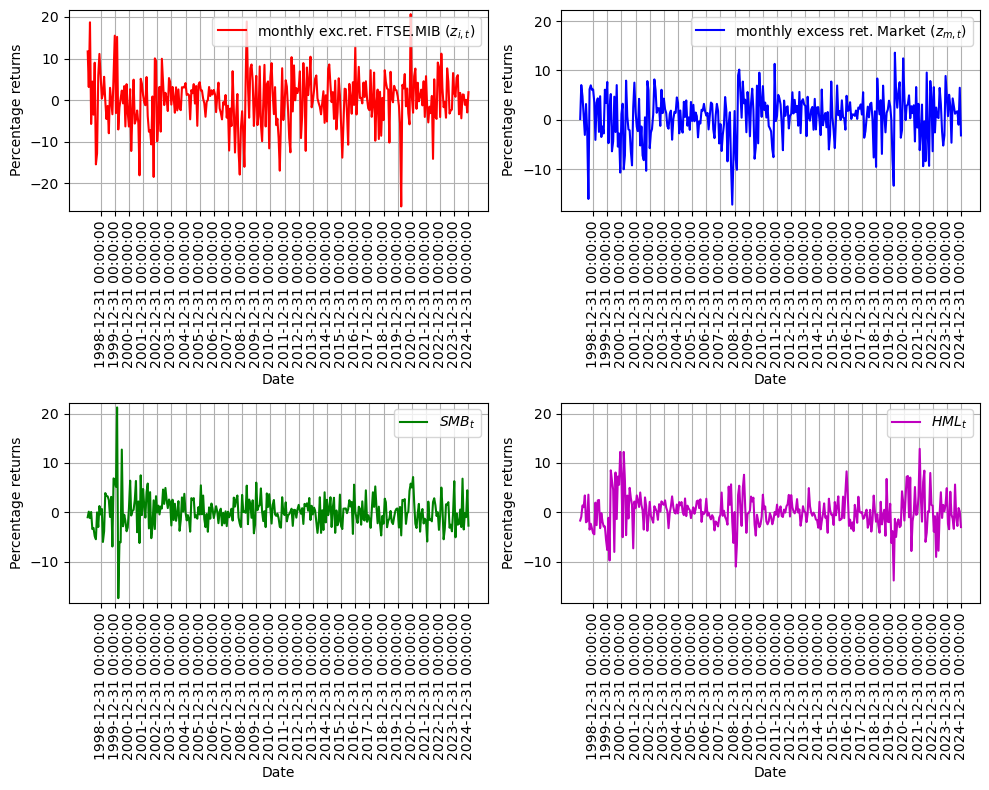

In [37]:
#Plot the Factors and the Excess Return

d2plot = z_m_df

min_ftse_exc = d2plot['Exc_Ret_FTSE'].min() - 1
max_ftse_exc = d2plot['Exc_Ret_FTSE'].max() + 1

#Compute max and min (add +/- 1 to improve the data viz)
columns_for_shared_range = ['Mkt-RF', 'SMB', 'HML']
min_shared = d2plot[columns_for_shared_range].min().min() - 1
max_shared = d2plot[columns_for_shared_range].max().max() + 1

#Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

#Plot 1: FTSE MIB Excess Return 
axs[0, 0].plot(d2plot.index, d2plot['Exc_Ret_FTSE'], 'r-', label='monthly exc.ret. FTSE.MIB ($z_{i,t}$)')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Percentage returns')
axs[0, 0].set_ylim(min_ftse_exc, max_ftse_exc) 
axs[0, 0].set_xticks(date_lab)
axs[0, 0].set_xticklabels(date_lab, rotation=90)
axs[0, 0].legend()
axs[0, 0].grid(True)

#Plot 2: Mkt-RF
axs[0, 1].plot(d2plot.index, d2plot['Mkt-RF'], 'b-', label='monthly excess ret. Market ($z_{m,t}$)')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Percentage returns')
axs[0, 1].set_ylim(min_shared, max_shared)
axs[0, 1].set_xticks(date_lab)
axs[0, 1].set_xticklabels(date_lab, rotation=90)
axs[0, 1].legend()
axs[0, 1].grid(True)

#Plot 3: SMB 
axs[1, 0].plot(d2plot.index, d2plot['SMB'], 'g-', label='$SMB_{t}$')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Percentage returns')
axs[1, 0].set_ylim(min_shared, max_shared) 
axs[1, 0].set_xticks(date_lab)
axs[1, 0].set_xticklabels(date_lab, rotation=90)
axs[1, 0].legend()
axs[1, 0].grid(True)

#Plot 4: HML 
axs[1, 1].plot(d2plot.index, d2plot['HML'], 'm-', label='$HML_{t}$')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Percentage returns')
axs[1, 1].set_ylim(min_shared, max_shared) 
axs[1, 1].set_xticks(date_lab)
axs[1, 1].set_xticklabels(date_lab, rotation=90)
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
#plt.savefig("Regression Variables.png")
plt.show()